<a href="https://colab.research.google.com/github/mickvanhulst/twitter_bitcoin_analysis/blob/master/models/CNN_btc_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install PyTorch

In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

!pip install git+git://github.com/mickvanhulst/livelossplot.git --upgrade

tcmalloc: large alloc 1073750016 bytes == 0x5c49c000 @  0x7ff842a6b2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.0
True
  Cloning git://github.com/mickvanhulst/livelossplot.git to /tmp/pip-req-build-oiv454p2
  Running setup.py bdist_wheel for livelossplot ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-ebvhxtux/wheels/73/e2/09/79ee9f5b0be18dc9c6ee17f0dc181708c1cf9513c70053ca92
Successfully built livelossplot


# Test if GPU enabled

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Load packages

In [3]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.utils.data as utils

from livelossplot import PlotLosses
import matplotlib
import matplotlib.pyplot as plt

from google.colab import drive

import numpy as np
import time
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


# Mount Drive and open matrices

In [4]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import re

def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s
     
def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    
    amazing <3 RegExp
    """
    l.sort(key=alphanum_key)
    return l

In [6]:
import os

model_type = ['keywords_tfidf_p', 'keywords_clusters'][0]
mode = ['count', 'binary'][0]
INPUT_SIZE_CNN = 25 if model_type == 'keywords_clusters' else 200
train, test = None, None
train_classes, train_user_data, train_matrices, train_dates, train_btc_meta_data, train_classes_t = None, None, None, None, None, None

base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc/{}/{}/train/'.format(model_type, mode)
files = os.listdir(base_str)
for train_file in sort_nicely(files):
    if 'btc' in train_file:
        temp = np.load(base_str + train_file)
        if train_btc_meta_data is None:
            train_btc_meta_data = temp
        else:
            train_btc_meta_data = np.concatenate((train_btc_meta_data, temp), axis=0)
    elif 'tc_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_classes_t is None:
            train_classes_t = temp
        else:
            train_classes_t = np.concatenate((train_classes_t, temp), axis=0)
    elif 'c_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_classes is None:
            train_classes = temp
        else:
            train_classes = np.concatenate((train_classes, temp), axis=0)
    elif 'md_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_user_data is None:
            train_user_data = temp
        else:
            train_user_data = np.vstack((train_user_data, temp))
    elif 'dp_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_matrices is None:
            train_matrices = temp
        else:
            train_matrices = np.vstack((train_matrices, temp))
    elif 'dt_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_dates is None:
            train_dates = temp
        else:
            train_dates = np.concatenate((train_dates, temp), axis=0)

test_classes, test_user_data, test_matrices, test_dates, test_btc_meta_data, test_classes_t = None, None, None, None, None, None
base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc/{}/{}/test/'.format(model_type, mode)

print('Starting with test files.')

for test_file in sort_nicely(os.listdir(base_str)):
    if 'btc' in test_file:
        temp = np.load(base_str + test_file)
        if test_btc_meta_data is None:
            test_btc_meta_data = temp
        else:
            test_btc_meta_data = np.concatenate((test_btc_meta_data, temp), axis=0)
    elif 'tc_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_classes_t is None:
            test_classes_t = temp
        else:
            test_classes_t = np.concatenate((test_classes_t, temp), axis=0)
    elif 'c_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_classes is None:
            test_classes = temp
        else:
            test_classes = np.concatenate((test_classes, temp), axis=0)
    elif 'md_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_user_data is None:
            test_user_data = temp
        else:
            test_user_data = np.vstack((test_user_data, temp))
    elif 'dp_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_matrices is None:
            test_matrices = temp
        else:
            test_matrices = np.vstack((test_matrices, temp))
    elif 'dt_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_dates is None:
            test_dates = temp
        else:
            test_dates = np.concatenate((test_dates, temp), axis=0)
            
print('Test shapes: ', test_classes_t.shape, test_classes.shape, test_user_data.shape, 
      test_matrices.shape, test_dates.shape, test_btc_meta_data.shape)

print('Train shapes: ', train_classes_t.shape, train_classes.shape, train_user_data.shape, 
      train_matrices.shape, train_dates.shape, train_btc_meta_data.shape)

Starting with test files.
Test shapes:  (26565,) (26565,) (26565, 8) (26565, 200, 7) (26565,) (26565, 8)
Train shapes:  (144162,) (144162,) (144162, 8) (144162, 200, 7) (144162,) (144162, 8)


In [0]:
# TEMP
# test_matrices = test_matrices[:25500]
# test_user_data = test_user_data[:25500]
# test_classes = test_classes[:25500]
# test_dates = test_dates[:25500]

# train_matrices = train_matrices[:144578]
# train_user_data = train_user_data[:144578]
# train_classes = train_classes[:144578]
# train_dates = train_dates[:144578]
# train_btc_meta_data = train_btc_meta_data[:144578]

In [0]:
# Re-assign tokens for userIds as this makes normalization easier (no precision errors).
unique_users = np.unique(np.concatenate((np.unique(train_user_data[:,-1]), np.unique(test_user_data[:,-1]))))
user_ids = {}
for i, v in enumerate(unique_users):
    user_ids[v] = (i+1)

for i, v in enumerate(train_user_data):
    train_user_data[i,-1] = user_ids[v[-1]]
    
for i, v in enumerate(test_user_data):
    test_user_data[i,-1] = user_ids[v[-1]]

In [0]:
scaler = StandardScaler()
scaler.fit(train_user_data)
train_user_data = scaler.transform(train_user_data)
test_user_data = scaler.transform(test_user_data)

In [0]:
#scalers = {}
for i in range(train_matrices.shape[2]):
    #scalers[i] = StandardScaler()
    train_matrices[:, i, :] = scalers[i].fit_transform(train_matrices[:, i, :]) 

for i in range(test_matrices.shape[2]):
    test_matrices[:, i, :] = scalers[i].transform(test_matrices[:, i, :]) 

# Some analysis

## Feature analysis

In [24]:
'''
Calculates feature importance for each feature on a day-by-day basis.

This way we can evaluate which feature of a particular day is important
in comparison to the class result.
'''

from sklearn.feature_selection import mutual_info_classif

# Calculate impact of features on classes separately.
train_mi = {}
train_mi_tc = {}
for i in range(train_matrices.shape[2]):
    train_mi[i] = mutual_info_classif(train_matrices[:, :, i], train_classes)
    train_mi_tc[i] = mutual_info_classif(train_matrices[:, :, i], train_classes_t)
    print('Done {}'.format(i / train_matrices.shape[2]))

np.save('/content/gdrive/My Drive/Colab Notebooks/data/btc/train_mi_c.npy', np.array(train_mi))
np.save('/content/gdrive/My Drive/Colab Notebooks/data/btc/train_mi_tc.npy', np.array(train_mi_tc))

Done 0.0
Done 0.14285714285714285
Done 0.2857142857142857
Done 0.42857142857142855
Done 0.5714285714285714
Done 0.7142857142857143
Done 0.8571428571428571


In [33]:

np.sum(np.sum(train_mi_tc[i] for i in range(7)))

0.8319400209859054

## Check distribution of nonzeroes for training matrices and test data

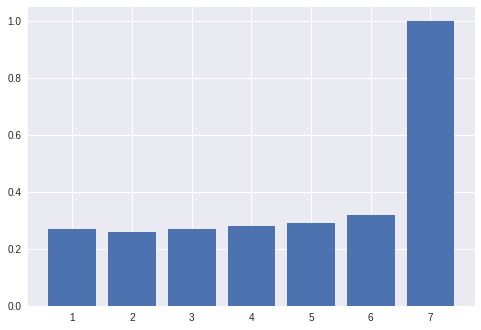

[49130, 32207, 21824, 14793, 13843, 6862, 5919]


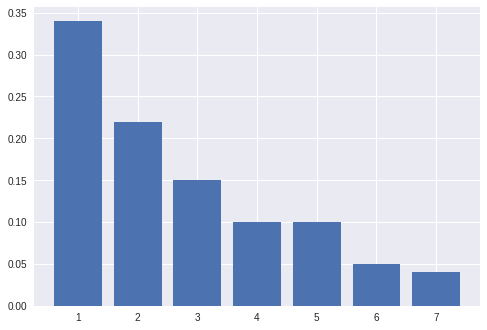

In [0]:
copy_train = train_matrices
copy_test = test_matrices
copy_train_user_data = train_user_data
copy_test_user_data = test_user_data

# How many of the training matrices just have 1 non-row column.
cnt = 0
indices = []
dist = [0, 0, 0, 0, 0, 0, 0]
amnt_dist = [0, 0, 0, 0, 0, 0, 0]
for i in range(len(copy_train)):
    sum_of_matrix = copy_train[i].sum(axis=0)
    nonzeroes = np.nonzero(sum_of_matrix)[0]
    for j in nonzeroes:
        dist[j] += 1
    
    amnt_non_zero = len(nonzeroes)
    amnt_dist[amnt_non_zero-1] += 1
    if amnt_non_zero == 1:
        cnt +=1
        indices.append(i)
# Which days are filled.
plt.bar(range(1, 8), [round(x / len(copy_train), 2) for x in dist])
plt.show()
print(amnt_dist)
plt.bar(range(1, 8), [round(x / len(copy_train), 2) for x in amnt_dist])
plt.show()


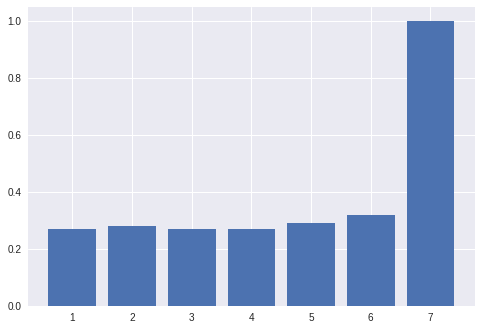

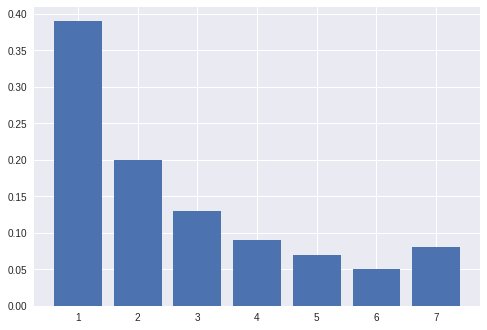

In [0]:
# How many of the training matrices just have 1 non-row column.
cnt = 0
indices = []
dist = [0, 0, 0, 0, 0, 0, 0]
amnt_dist = [0, 0, 0, 0, 0, 0, 0]

for i in range(len(copy_test)):
    sum_of_matrix = copy_test[i].sum(axis=0)
    nonzeroes = np.nonzero(sum_of_matrix)[0]
    for j in nonzeroes:
        dist[j] += 1
    
    amnt_non_zero = len(nonzeroes)
    amnt_dist[amnt_non_zero-1] += 1
    if amnt_non_zero == 1:
        cnt +=1
        indices.append(i)
plt.bar(range(1, 8), [round(x / len(copy_test), 2) for x in dist])
plt.show()

plt.bar(range(1, 8), [round(x / len(copy_test), 2) for x in amnt_dist])
plt.show()

In [0]:
# train_matrices = np.delete(copy_train, indices, axis=0)
# train_classes = np.delete(train_classes, indices)
# train_user_data = np.delete(train_user_data, indices, axis=0)
# train_dates = np.delete(train_dates, indices)
# train_matrices.shape, train_classes.shape, train_user_data.shape

((63241, 25, 7), (63241,), (63241, 8))

## Check distribution of user-data to find important users.

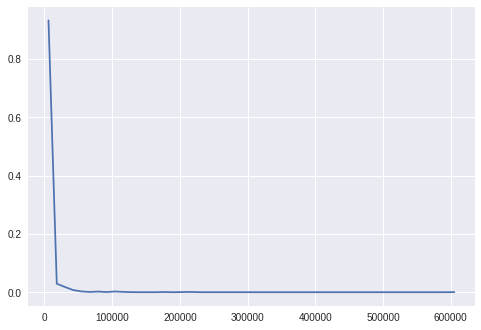

In [0]:
'''
TODO: find important users and filter entire dataset, including test set based on
those userIds. So every user that occurs in the test set, should also occur in 
training set. Else, it's removed.

Perhaps that should be my main criteria, not the amount of followers.
'''
# [['verified', 'followers_count', 'friends_count',
#                                'listed_count', 'favourites_count', 'statuses_count', 'unix_months',
#                                'twitter_user_id']]


# Histogram
heights,bins = np.histogram(copy_train_user_data[:, 1],bins=50)

# Normalize
heights = heights/float(sum(heights))
binMids=bins[:-1]+np.diff(bins)/2.
plt.plot(binMids,heights)

In [9]:
perc = 10
indices = np.argwhere(train_user_data[:, 1] <= np.percentile(train_user_data[:, 1], perc)).flatten()

train_matrices = np.delete(train_matrices, indices, axis=0)
train_classes_t = np.delete(train_classes_t, indices)
train_user_data = np.delete(train_user_data, indices, axis=0)
train_dates = np.delete(train_dates, indices)
train_matrices.shape, train_classes_t.shape, train_user_data.shape

((129519, 200, 7), (129519,), (129519, 8))

In [10]:
indices = np.argwhere(test_user_data[:, 1] <= np.percentile(train_user_data[:, 1], perc)).flatten()

test_matrices = np.delete(test_matrices, indices, axis=0)
test_classes_t = np.delete(test_classes_t, indices)
test_user_data = np.delete(test_user_data, indices, axis=0)
test_dates = np.delete(test_dates, indices)
test_matrices.shape, test_classes_t.shape, test_user_data.shape,test_dates.shape

((18133, 200, 7), (18133,), (18133, 8), (18133,))

## See which test users are not in train NOTE: SHOULD REMOVE FROM BOTH SIDES.

In [11]:
indices = []
test_user_ids = np.unique(test_user_data[:,-1])
for i in range(len(train_user_data[:,-1])):
    if train_user_data[i,-1] not in test_user_ids:
        indices.append(i)
        
len(indices) / len(train_user_data[:,-1])

0.24760073811564326

In [12]:
train_matrices = np.delete(train_matrices, indices, axis=0)
train_classes_t = np.delete(train_classes_t, indices)
train_user_data = np.delete(train_user_data, indices, axis=0)
train_dates = np.delete(train_dates, indices)
train_matrices.shape, train_classes_t.shape, train_user_data.shape

((97450, 200, 7), (97450,), (97450, 8))

### Compare occurences users training versus test set

In [0]:
unique, counts = np.unique(train_user_data[:,-1], return_counts=True)
cnt_train = dict(zip(unique, counts))
unique, counts = np.unique(test_user_data[:,-1], return_counts=True)
cnt_test = dict(zip(unique, counts))

cnt_train, cnt_test

({8.396305625524769e-05: 21,
  1.0000839630562552: 7,
  2.0000839630562552: 6,
  5.000083963056255: 8,
  6.000083963056255: 8,
  8.000083963056255: 9,
  10.000083963056255: 19,
  11.000083963056255: 7,
  14.000083963056255: 4,
  15.000083963056255: 15,
  16.000083963056255: 3,
  17.000083963056255: 5,
  19.000083963056255: 16,
  21.000083963056255: 1,
  25.000083963056255: 1,
  26.000083963056255: 3,
  28.000083963056255: 6,
  33.000083963056255: 31,
  35.000083963056255: 1,
  40.000083963056255: 20,
  41.000083963056255: 6,
  42.000083963056255: 2,
  44.000083963056255: 30,
  45.000083963056255: 1,
  46.000083963056255: 3,
  49.000083963056255: 7,
  50.000083963056255: 5,
  55.000083963056255: 25,
  56.000083963056255: 10,
  57.000083963056255: 10,
  59.000083963056255: 14,
  60.000083963056255: 58,
  62.000083963056255: 1,
  67.00008396305626: 1,
  68.00008396305626: 4,
  69.00008396305626: 41,
  70.00008396305626: 67,
  72.00008396305626: 2,
  74.00008396305626: 7,
  82.000083963056

## See which train users are not in test

In [13]:
indices = []
train_user_ids = np.unique(train_user_data[:,-1])
for i in range(len(test_user_data[:,-1])):
    if test_user_data[i,-1] not in train_user_ids:
        indices.append(i)
        
len(indices) / len(test_user_data[:,-1])

0.1246897920917664

In [14]:
test_matrices = np.delete(test_matrices, indices, axis=0)
test_classes_t = np.delete(test_classes_t, indices)
test_user_data = np.delete(test_user_data, indices, axis=0)
test_dates = np.delete(test_dates, indices)
test_matrices.shape, test_classes_t.shape, test_user_data.shape

((15872, 200, 7), (15872,), (15872, 8))

### Compare occurences users training versus test set

In [0]:
'''
NOTE: Amount of occurences is SUPER low, so I'm pretty sure we can't map any 
relevant information for a user.
'''

unique, counts = np.unique(train_user_data[:,-1], return_counts=True)
cnt_train = dict(zip(unique, counts))
unique, counts = np.unique(test_user_data[:,-1], return_counts=True)
cnt_test = dict(zip(unique, counts))

list_users_occ = [k for k,v in cnt_train.items() if v > 10]
list_users_occ, cnt_train

([8.39137366786943e-05,
  0.0009230511034656374,
  0.0013426197868591089,
  0.001678274733573886,
  0.0028530670470756064,
  0.0034404632038264665,
  0.0037761181505412437,
  0.004363514307292104,
  0.004699169254006881,
  0.005034824200721658,
  0.005118737937400353,
  0.00545439288411513,
  0.005873961567508601,
  0.005957875304187296,
  0.00604178904086599,
  0.0062096165142233786,
  0.006964840144331627,
  0.008223546194512042,
  0.009230511034656374,
  0.009314424771335067,
  0.009398338508013762,
  0.009817907191407233,
  0.01015356213812201,
  0.010405303348158094,
  0.010740958294872871,
  0.010824872031551564,
  0.01090878576823026,
  0.010992699504908953,
  0.011412268188302425,
  0.011496181924981119,
  0.012167491818410673,
  0.012587060501804146,
  0.01367793907862717,
  0.014181421498699337,
  0.014600990182092809,
  0.015188386338843668,
  0.015272300075522363,
  0.016279264915666693,
  0.016447092389024084,
  0.01653100612570278,
  0.01661491986238147,
  0.0169505748090

# Device config


In [15]:
# Device configuration
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

# Process data and set parameters

In [49]:
'''
THIS DOESN'T WORK WELL YET.
'''
from sklearn.preprocessing import OneHotEncoder

train_classes_t[train_classes_t == -1] = 2
test_classes_t[test_classes_t == -1] = 2

enc = OneHotEncoder()
enc.fit(train_classes_t.reshape(-1, 1))

# 3. Transform
train_classes_t = enc.transform(train_classes_t.reshape(-1, 1)).toarray()
test_classes_t = enc.transform(test_classes_t.reshape(-1, 1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(array([[0., 1.],
        [1., 0.],
        [0., 1.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]]), array([[1., 0.],
        [0., 1.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]]))

In [50]:
# Hyper parameters
num_epochs = 50
num_classes = 3#1
batch_size = 128
learning_rate = 0.1
size_user_info = 8

# print('''Occurences of zero/one vs total amount of 
# classes for train and test set:
# -------------------------------''')
# for d in [train_classes, test_classes]:
#     occ_zero = len([x for x in d if x == 0])
#     occ_one = len(d) - occ_zero
#     print(occ_one, occ_zero, len(d))

tensor_1 = torch.from_numpy(train_matrices)
tensor_2 = torch.from_numpy(train_classes_t.astype(float))#train_classes)
tensor_3 = torch.from_numpy(train_user_data.astype(float))
tensor_4 = torch.from_numpy(train_dates.astype(float))
full_dataset = torch.utils.data.TensorDataset(tensor_1, tensor_2, tensor_3, tensor_4)

tensor_1 = torch.from_numpy(test_matrices)
tensor_2 = torch.from_numpy(test_classes_t)#test_classes)
tensor_3 = torch.from_numpy(test_user_data.astype(float))
tensor_4 = torch.from_numpy(test_dates.astype(float))

test = torch.utils.data.TensorDataset(tensor_1, tensor_2, tensor_3, tensor_4)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=batch_size,
                                          drop_last=True,
                                          shuffle=False)

AssertionError: ignored

# Model

## Setup Model

In [0]:
# # https://github.com/rodgzilla/machine_learning_pytorch_simple_cnn_1d_nlp/blob/master/notebooks/CNN%201D.ipynb
# class ConvNet(nn.Module):
#     def __init__(self, num_classes):
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv1d(25, 32, kernel_size=5, stride=1, padding=2) #prev was 25, 12, 5
#         self.conv2 = nn.Conv1d(32, 16, kernel_size=5, stride=1, padding=1)
#         self.conv3 = nn.Conv1d(16, 16, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(5*16, 32)
#         self.bn1 = nn.BatchNorm1d(32)
#         self.fc2 = nn.Linear(32, 16)
#         self.bn2 = nn.BatchNorm1d(16)
#         self.fc3 = nn.Linear(16, num_classes) #+ size_user_info, num_classes)
#         self.out_act = nn.Sigmoid()

#     def forward(self, x, user_data):
#         x = x.view(batch_size, 25, 7).float()
#         #print(x.shape)
#         x = F.relu(self.conv1(x))
#         #print(x.shape)
#         x = F.relu(self.conv2(x))
#         #print(x.shape)
#         x = F.relu(self.conv3(x))
#         #print(x.shape)
#         x = x.view(x.shape[0], -1)
#         #print(x.shape)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         #x = torch.cat((x, user_data.float()), 1)
#         x = self.fc3(x)
#         x = self.out_act(x)
#         return x.view(-1, batch_size).squeeze()

# https://github.com/rodgzilla/machine_learning_pytorch_simple_cnn_1d_nlp/blob/master/notebooks/CNN%201D.ipynb
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(INPUT_SIZE_CNN, 32, kernel_size=5, stride=1, padding=2) #prev was 25, 12, 5
        self.conv2 = nn.Conv1d(32, 16, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(5*8, 32)
        self.bn1 = nn.BatchNorm1d(32)
        #self.fc2 = nn.Linear(32, 16)
        #self.bn2 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(32 + size_user_info, num_classes)
        #self.out_act = nn.Sigmoid()

    def forward(self, x, user_data):
        x = x.view(batch_size, INPUT_SIZE_CNN, 7).float()
        #print(x.shape)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = torch.cat((x, user_data.float()), 1)
        x = self.fc2(x)
        #x = self.out_act(x)
        return x#.view(-1, batch_size).squeeze()


model = ConvNet(num_classes).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [117]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

36499

## (Optional) Load model

In [0]:
base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc'
model = model.load_state_dict(torch.load('{}/model_{}_{}_{}.ckpt'.format(
    base_str, num_epochs, batch_size, 'cluster')))


NameError: ignored

## Methods

In [0]:
def validate_model(val_loader):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        pred = []
        y = []
        losses = []
        for images, labels, user_data, dates in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            user_data = user_data.to(device)
            outputs = model(images, user_data)
            
            pred.extend(outputs.data.cpu().numpy())
            #y.extend(labels.data.cpu().numpy())
            
            loss = criterion(outputs, labels.float())
            losses.append(loss.data.cpu().numpy())
            
        losses = np.mean(losses)
        #fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
        auc = 0#metrics.auc(fpr, tpr)
        print('Epoch [{}/{}], val acc: {}, val loss: {}'
              .format(epoch + 1, num_epochs, auc, losses))
        return losses, auc

def train_model(train_loader):
    correct = 0
    total = 0
    losses = []
    pred = []
    y = []
    for i, (images, labels, user_data, dates) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)        
        user_data = user_data.to(device)
        
        # Forward pass
        outputs = model(images, user_data)
        loss = criterion(outputs, labels)#.float())
        #losses.append(loss.data.cpu().numpy())
        
        # For AUC score.
        #pred.extend(outputs.data.cpu().numpy())
        #y.extend(labels.data.cpu().numpy())
            
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % int(len(train_loader) / 3)  == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, np.mean(losses)))
    
    #fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
    auc = 0#metrics.auc(fpr, tpr)
    
    return np.mean(losses), auc


def test_model(test_loader):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        pred = []
        y = []
        for images, labels, user_data, dates in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            user_data = user_data.to(device)
            outputs = model(images, user_data)
            
            # For AUC score.
            pred.extend(outputs.data.cpu().numpy())
            y.extend(labels.data.cpu().numpy())
        
        #fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
        auc = 0#metrics.auc(fpr, tpr)
        print('Test AUC of the model on the test images: {}%'.format(auc))
        
    return auc

## K-Fold CV

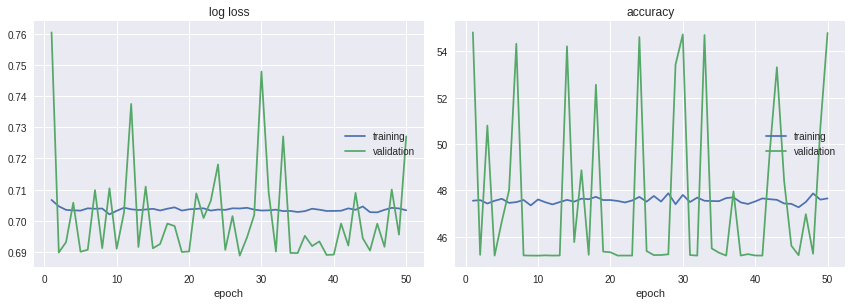

log loss:
training   (min:    0.702, max:    0.707, cur:    0.703)
validation (min:    0.689, max:    0.760, cur:    0.727)

accuracy:
training   (min:   47.266, max:   47.872, cur:   47.650)
validation (min:   45.178, max:   54.821, cur:   54.797)
Final validation loss for current fold: 0.7270606756210327
-------------------------------
2-fold validation has been executed, mean validation loss: 0.7112228870391846


In [0]:
# Train the model
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                                                       verbose=True, patience=8)
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True)
fold_val_losses = []
saved_plots = []
file_name_base = '/content/gdrive/My Drive/Colab Notebooks/data/btc/plots/{}_fold_'.format(time.time())
fold = 0
for train_indexes, validation_indexes in kf.split(full_dataset):
    fold += 1
    liveloss = PlotLosses(save_img=True, file_name=file_name_base + str(fold) + '.png')

    train = torch.utils.data.dataset.Subset(full_dataset, train_indexes)
    validation = torch.utils.data.dataset.Subset(full_dataset, validation_indexes)
    
    model = ConvNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    # Set train and validation data loaders.
    train_loader = torch.utils.data.DataLoader(dataset=train,
                                               batch_size=batch_size,
                                               drop_last=True,
                                               shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=validation,
                                              batch_size=batch_size,
                                              drop_last=True,
                                              shuffle=True)
    total_step = len(train_loader)
    print('-------------------------------')
    print('Starting training for new fold')
    print('-------------------------------')
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(train_loader)
        val_loss, val_acc = validate_model(val_loader)
        scheduler.step(val_loss)
        liveloss.update({
            'log loss': train_loss,
            'val_log loss': val_loss,
            'accuracy': train_acc,
            'val_accuracy': val_acc
        })
        liveloss.draw()
    
    print('Final validation loss for current fold: {}'.format(val_loss))
    fold_val_losses.append(val_loss)
    saved_plots.append(liveloss)
    
print('-------------------------------')
print('{}-fold validation has been executed, mean validation loss: {}'.
      format(n_folds, np.mean(fold_val_losses)))

np.save('/content/gdrive/My Drive/Colab Notebooks/data/btc/plots_crossval_{}_{}_{}.npy'.
        format(num_epochs, batch_size, time.time()), np.array(saved_plots))

### Note: unfortunately the function above overwrites older plots. However, I've saved them into the list below. So you can access them by simply accessing the corresponding index.

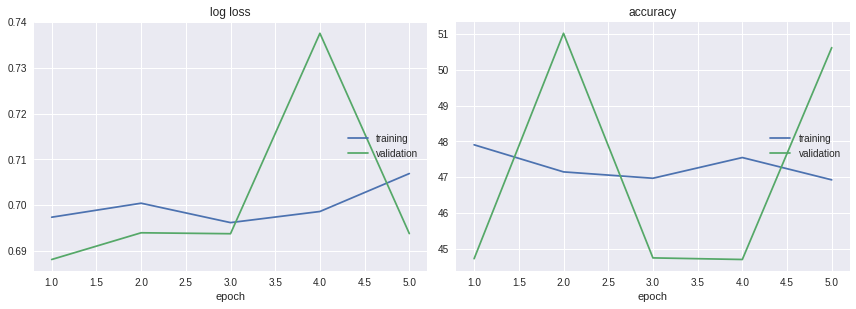

log loss:
training   (min:    0.696, max:    0.707, cur:    0.707)
validation (min:    0.688, max:    0.738, cur:    0.694)

accuracy:
training   (min:   46.925, max:   47.906, cur:   46.925)
validation (min:   44.697, max:   51.025, cur:   50.624)


In [0]:
saved_plots[1].draw()


## Train and test final model

In [43]:
'''
Thus far best with lr=0.001 and Adam, no reduceLronplateau yet and batch_size 32.

Seems to work better without user-data, could be due to the sheer amount of user-data
in respective training/validation/test sets. E.g. User A might be very present in training set, but not so much in validation/test set.

When removing users with a lower than 25th percentile amount of followers doesn't help.
'''

# Init model
model = ConvNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)#

# Set train and validation data loaders.
len_train = int(len(full_dataset) * 0.8)
len_val = len(full_dataset) - len_train

train, validation = torch.utils.data.dataset.random_split(full_dataset, [len_train, len_val])


train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size,
                                           drop_last=True,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=validation,
                                          batch_size=batch_size,
                                          drop_last=True,
                                          shuffle=True)

total_step = len(train_loader)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
#                                                       verbose=True, patience=5)

train_losses, train_aucs, val_losses, val_aucs = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_auc = train_model(train_loader)
    val_loss, val_auc = validate_model(val_loader)
    train_losses.append(train_loss)
    train_aucs.append(train_auc)
    val_losses.append(val_loss)
    val_aucs.append(val_aucs)
    print('At end of epoch, average (training) loss: {}, auc: {} '.format(train_loss, train_auc))
    print('At end of epoch, average (validation) loss: {}, auc: {} '.format(val_loss, val_auc))
    #scheduler.step(val_loss)

acc = test_model(test_loader)

# Save the model checkpoint
torch.save(model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/data/btc/models/model_{}_{}_{}_{}_{}.ckpt'.format(
    num_epochs, batch_size, model_type, acc, time.time()))

RuntimeError: ignored

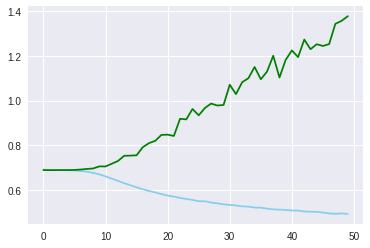

In [79]:
# Make plot.
plt.plot(train_losses, color='skyblue')
plt.plot(val_losses, color='green')
plt.show()

In [0]:
plt.plot(train_aucs, color='skyblue')
plt.plot(val_aucs, color='green')
plt.show()

In [0]:
acc = test_model(test_loader)

# Trading strategy

## Perform forward pass on training set to generate data for Logistic Regression and majority vote

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train,batch_size=batch_size, shuffle=False, drop_last=True)
train_lr = None

model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    for images, labels, user_data, dates in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        user_data = user_data.to(device)
        outputs = model(images, user_data)
        predicted = (0.5 > outputs).float() * 1
        #print(predicted)
        #predicted = np.array([x[0] for x in predicted.data.cpu().numpy()])
        #outputs = np.array([x[0] for x in outputs.data.cpu().numpy()])
        #labels = np.array([x for x in labels.data.cpu().numpy()])
        temp = np.dstack((outputs, labels, 
                               user_data.data.cpu().numpy()[:,-1],
                               dates.data.cpu().numpy(), predicted)).squeeze()
        if train_lr is None:
            train_lr = temp
        else:
            train_lr = np.concatenate((train_lr, temp), axis=0)

In [0]:
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False, drop_last=True)
test_lr = None

model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    for images, labels, user_data, dates in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        user_data = user_data.to(device)
        outputs = model(images, user_data)
        predicted = (0.5 > outputs).float() * 1
        
        #predicted = np.array([x[0] for x in predicted.data.cpu().numpy()])
        #outputs = np.array([x[0] for x in outputs.data.cpu().numpy()])
        #labels = np.array([x for x in labels.data.cpu().numpy()])
        temp = np.dstack((outputs, labels.data.cpu().numpy(), 
                               user_data.data.cpu().numpy()[:,-1],
                               dates.data.cpu().numpy(), predicted)).squeeze()
        if test_lr is None:
            test_lr = temp
        else:
            test_lr = np.concatenate((test_lr, temp), axis=0)

## Create dataframe for LR and MV

In [0]:
import pandas as pd

train_df = pd.DataFrame({'output':train_lr[:,0],'true':train_lr[:,1], 
                                   'user':train_lr[:,2], 'date':train_lr[:,3], 'pred_max':train_lr[:,4]})
test_df = pd.DataFrame({'output':test_lr[:,0],'true':test_lr[:,1], 
                                   'user':test_lr[:,2], 'date':test_lr[:,3], 'pred_max':test_lr[:,4]})

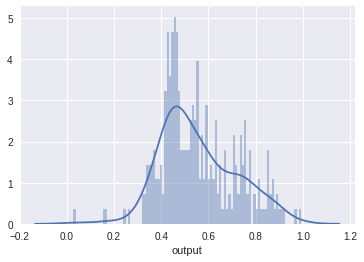

In [0]:
import seaborn 

seaborn.distplot(train_df['output'][train_df['date'] == 17548.0], bins=100)

## Perform Majority Vote and predict mean per date

In [83]:
data_MV = train_df[['date', 'output', 'true', 'pred_max']]
cnt_MV = 0
cnt_max = 0
pairs = []
dates = data_MV['date'].unique()
score = 0
for i in range(40, 55):
    threshold = i / 100
    cnt_MV = 0
    cnt_max = 0
    pairs = []
    for date in dates:
        temp = data_MV[data_MV['date'] == date]
        y_true = temp['true'].unique()[0]
        MV = temp['pred_max'].value_counts().index[0]
        max_all = temp['output'].mean()
        max_all = 1 if max_all > threshold else 0

        if y_true == MV:
            cnt_MV += 1
        if y_true == max_all:
            cnt_max += 1
            #print('correct', y_true, temp['output'].mean())
        else:
            #print('wrong', y_true, temp['output'].mean())
            pairs.append([max_all, y_true])
    new_score = cnt_max / len(dates)
    if new_score > score:
        best_thresh = threshold
        score = new_score
print('The best score was {} with threshold {}'.format(score, best_thresh))
print('Performing MV resulted in an acc of: {}'.format(cnt_MV / len(dates)))

The best score was 0.9908814589665653 with threshold 0.43
Performing MV resulted in an acc of: 0.14437689969604864


## Use best threshold for training set on test set to measure performance

wrong 0.0 0.4342067349036206
wrong 0.0 0.458828233934831
correct 0.0 0.42516046089524534
wrong 0.0 0.43871886334600785
wrong 0.0 0.4409081475544614
wrong 0.0 0.4458549093415599
wrong 0.0 0.4393875356390052
wrong 0.0 0.44317250414231746
wrong 0.0 0.4430152035646514
correct 0.0 0.4214710295790014
correct 1.0 0.46625026384186474
wrong 0.0 0.434159691136095
wrong 0.0 0.45224500554440283
correct 1.0 0.4642609877105429
wrong 0.0 0.46014366746397134
correct 1.0 0.4642138464716504
wrong 0.0 0.44866646612724914
correct 1.0 0.4374267460488891
wrong 0.0 0.4579128718164918
correct 1.0 0.44912556455719616
wrong 1.0 0.4273133463606626
correct 1.0 0.47344154986073633
wrong 0.0 0.4444914410769699
correct 1.0 0.44066585804294867
wrong 0.0 0.43029932966664663
wrong 0.0 0.45138193584724445
correct 1.0 0.45513575229623926
wrong 0.0 0.4587638891519745
wrong 0.0 0.4542428345655245
wrong 0.0 0.4694115976513459
The score on the test set is: 0.3333333333333333 with threshold 0.43
20 19 1


Text(0.5,257.44,'Predicted label')

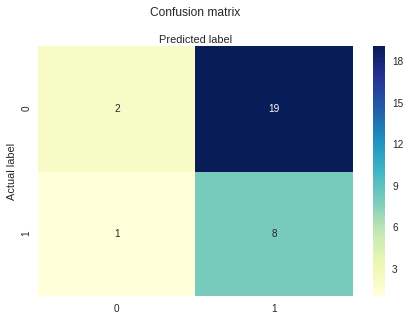

In [84]:
data_MV = test_df[['date', 'output', 'true', 'pred_max']]
cnt_max = 0
pairs = []
dates = data_MV['date'].unique()
y_train = []
y_pred = []
for date in dates:
    temp = data_MV[data_MV['date'] == date]
    y_true = temp['true'].unique()[0]
    MV = temp['pred_max'].value_counts().index[0]
    max_all = temp['output'].mean()
    max_all = 1 if max_all > best_thresh else 0
    y_train.append(y_true)
    y_pred.append(max_all)
    if y_true == max_all:
        cnt_max += 1
        print('correct', y_true, temp['output'].mean())
    else:
        print('wrong', y_true, temp['output'].mean())
        pairs.append([max_all, y_true])

print('The score on the test set is: {} with threshold {}'.format(cnt_max / len(dates), best_thresh))
print(len(pairs), len([x for x in pairs if x[0] == 1]), len([x for x in pairs if x[0] == 0]))
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Create required dataset for Logistic Regression

In [0]:
'''
For logistic regression we'd the following input:
[user_pred_1, .... user_pred_n]

We create a matrix with all zeroes and replace the user predictions if there
are any. If there's none, then we simply leave it at zero.

So we get a matrix per day with predictions for all users.
'''


# # Get all users
train_users = train_df['user'].unique()
test_users = test_df['user'].unique()
# print(train_users)
# print(test_users)
users = np.concatenate((train_users, test_users))
# # Assign users a unique id from 0 to n unique ids, 
# # create a dictionairy using training data and re-use during test time.
user_ids_lr = {}
for i, v in enumerate(users):
    user_ids_lr[v] = i

# Loop over dates, check if user has prediction
X_train = None
y_train = []
cnt = 0
for date in train_df['date'].unique():
    cnt += 1
    temp = train_df[train_df['date'] == date]
    arr = np.zeros(len(users))
    for row in temp.itertuples():
        usr = row[5]
        pred = row[2]
        lbl = row[4]
        arr[user_ids_lr[usr]] = pred
    y_train.append([lbl])
    if X_train is None:
        X_train = arr
    else:
        X_train = np.vstack((X_train, arr))

y_train = np.array(y_train)  

In [86]:
# Loop over dates, check if user has prediction
X_test = None
y_test = []
cnt = 0
cnt_n = 0
for date in test_df['date'].unique():
    cnt += 1
    temp = test_df[test_df['date'] == date]
    arr = np.zeros(len(users))
    for row in temp.itertuples():
        usr = row[5]
        pred = row[2]
        lbl = row[4]
        try:
            arr[user_ids_lr[usr]] = pred
        except:
            #print('User {} not found'.format(usr))
            cnt_n += 1
    y_test.append([lbl])
    if X_test is None:
        X_test = arr
    else:
        X_test = np.vstack((X_test, arr))

y_test = np.array(y_test)  
cnt_n / cnt 

0.0

## Perform Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression


# instantiate the model (using the default parameters)
logreg = LogisticRegression(C=0.55)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_train)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)
cnf_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[329,   3],
       [ 28, 298]])

In [89]:
y_pred = logreg.predict(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[14,  7],
       [ 5,  4]])

Text(0.5,257.44,'Predicted label')

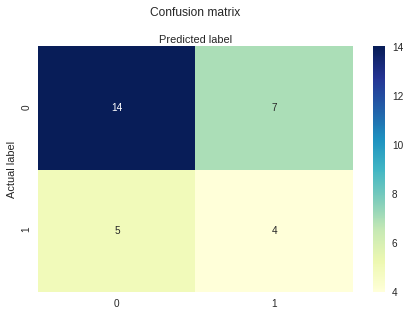

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')